In [1]:
# Dataset

In [2]:
import os, zipfile, requests

In [3]:
if not os.path.exists("bank-full.csv"):
    print("Downloading bank-full.csv file...")
    response = requests.get("https://archive.ics.uci.edu/static/public/222/bank+marketing.zip")
    with open("bank+marketing.zip", 'wb') as zip_file:
        zip_file.write(response.content)
    with zipfile.ZipFile("bank+marketing.zip", "r") as zip_file:
        zip_file.extractall()
    with zipfile.ZipFile("bank.zip", "r") as zip_file:
        zip_file.extractall()
    for file in [
        "bank+marketing.zip",
        "bank.zip",
        "bank-additional.zip",
        "bank.csv",
        "bank-names.txt",
    ]:
        os.remove(file)
    print("bank-full.csv was downloaded successfully.")
    
else:
    print("bank-full.csv is already downloaded.")

bank-full.csv is already downloaded.


In [4]:
# Data preparation

In [5]:
import pandas as pd
df = pd.read_csv("bank-full.csv", delimiter=";")
df = df[[
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y"
]]
df.isnull().sum() 

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
# Question 1

In [7]:
# df["education"].value_counts()
df["education"].mode()[0]

'secondary'

In [8]:
# Question 2.

In [9]:
import seaborn as sns

<Axes: >

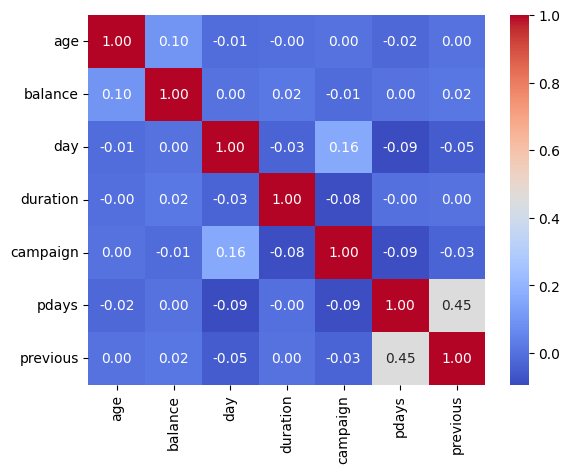

In [10]:
numerical = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
correlation_matrix = df[numerical].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [11]:
print("`age` and `balance`:\t", correlation_matrix["age"]["balance"].item())
print("`day` and `campaign`:\t", correlation_matrix["day"]["campaign"].item())
print("`day` and `pdays`:\t", correlation_matrix["day"]["pdays"].item())
print("`pdays` and `previous`:\t", correlation_matrix["pdays"]["previous"].item())

`age` and `balance`:	 0.09778273937134807
`day` and `campaign`:	 0.1624902163261922
`day` and `pdays`:	 -0.09304407377294048
`pdays` and `previous`:	 0.4548196354805043


In [12]:
# Target encoding

In [13]:
df.y = (df.y == 'yes').astype(int)

In [14]:
# Split the data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
RANDOM_STATE = 42
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=RANDOM_STATE)
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values
del df_train['y']
del df_val['y']
del df_test['y']

In [18]:
# Question 3.
categorical = df.columns[df.dtypes == "object"].to_list()
categorical

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [19]:
from sklearn.metrics import mutual_info_score

In [20]:
def mutual_info_y_score(series):
    return round(mutual_info_score(series, y_train), 2)

In [21]:
mi = df_train[categorical].apply(mutual_info_y_score)
mi.sort_values(ascending=False).index[0]

'poutcome'

In [22]:
# Question 4.

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [27]:
y_pred = model.predict_proba(X_val)[:, 1]
round(((y_pred >= 0.5) == y_val).mean().item(), 2)

0.9

In [28]:
# Question 5.

In [29]:
def get_X_train_and_X_val(features):
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_val

def train_model(X_train):
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

def validation_accuracy(X_val):
    y_pred = model.predict_proba(X_val)[:, 1]
    return ((y_pred >= 0.5) == y_val).mean().item()

In [30]:
X_train, X_val = get_X_train_and_X_val(categorical + numerical)
model = train_model(X_train)
all_features_y_acc = validation_accuracy(X_val)

In [31]:
for eliminated_feature in ["age", "balance", "marital", "previous"]:
    features = (categorical + numerical)
    features.remove(eliminated_feature)
    X_train, X_val = get_X_train_and_X_val(features)
    model = train_model(X_train)
    acc = validation_accuracy(X_val)
    print(eliminated_feature, ": ", abs(acc - all_features_y_acc))
    

age :  0.0
balance :  0.00022119000221187957
marital :  0.000774165007741634
previous :  0.00022119000221187957


In [32]:
# Question 6.

In [33]:
def train_model(X_train, C):
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

In [34]:
C_values = [0.01, 0.1, 1, 10, 100]

X_train, X_val = get_X_train_and_X_val(categorical + numerical)

for C in C_values:
    model = train_model(X_train, C)
    print(C, ": ", round(validation_accuracy(X_val), 3))

0.01 :  0.899
0.1 :  0.9
1 :  0.901
10 :  0.901
100 :  0.901
